# **Genetic algorithm for parameter tuning in Tabu Search**

This work presents a ***hyperheuristic-based*** approach that uses a Genetic Algorithm (GA) to evolve configurations—represented as chromosomes—that define different Tabu Search (TS) strategies. Each chromosome encodes a set of key parameters, such as neighborhood structure, tabu tenure, aspiration criteria, and stopping conditions. The fitness of each chromosome is evaluated based on the performance of the Tabu Search algorithm, configured with those parameters, on a given graph coloring instance. This hyperheuristic framework enables the automated discovery of effective parameter settings, improving both the quality and efficiency of the solutions.


## **Membres d'équipe 01**


*   AOULMI Lina
*   AMOURA Yousra
*   LAOUAZI Lina
*   HAMADENE Kamlia
*   OUIKENE Youcef
*   OUADI Amina

Groupe : SIQ2

In [ ]:
#@title **Chromosome Representation**
from IPython.display import Markdown

table = """
| Index | Parameter           | Type | Possible Values | Description |
|-------|---------------------|------|-----------------|-------------|
| 0     | init_strategy       | int  | 0-2             | Initial coloring method: 0=Random, 1=Greedy, 2=DSATUR |
| 1     | neighborhood_type   | int  | 0-2             | Move generation strategy: 0=Swap, 1=Insert, 2=Kempe Chain |
| 2     | tabu_tenure         | int  | 3-20            | Number of iterations a move stays tabu |
| 3     | tabu_list_type      | int  | 0-1             | Tabu list implementation: 0=Move-based, 1=Attribute-based |
| 4     | aspiration_rule     | int  | 0-2             | Aspiration criteria: 0=None, 1=Best-so-far, 2=Threshold |
| 5     | acceptance_rule     | int  | 0-2             | Move acceptance: 0=Greedy, 1=First-improving, 2=Random |
| 6     | diversify_trigger   | int  | 5-50            | Iterations without improvement before diversification |
| 7     | stop_criterion      | int  | 0-1             | Stopping condition: 0=Max iterations, 1=Stagnation |
"""

display(Markdown(table))


| Index | Parameter           | Type | Possible Values | Description |
|-------|---------------------|------|-----------------|-------------|
| 0     | init_strategy       | int  | 0-2             | Initial coloring method: 0=Random, 1=Greedy, 2=DSATUR |
| 1     | neighborhood_type   | int  | 0-2             | Move generation strategy: 0=Swap, 1=Insert, 2=Kempe Chain |
| 2     | tabu_tenure         | int  | 3-20            | Number of iterations a move stays tabu |
| 3     | tabu_list_type      | int  | 0-1             | Tabu list implementation: 0=Move-based, 1=Attribute-based |
| 4     | aspiration_rule     | int  | 0-2             | Aspiration criteria: 0=None, 1=Best-so-far, 2=Threshold |
| 5     | acceptance_rule     | int  | 0-2             | Move acceptance: 0=Greedy, 1=First-improving, 2=Random |
| 6     | diversify_trigger   | int  | 5-50            | Iterations without improvement before diversification |
| 7     | stop_criterion      | int  | 0-1             | Stopping condition: 0=Max iterations, 1=Stagnation |


In [ ]:
#@title **Imports**
import random
import time
import networkx as nx
import numpy as np
from collections import defaultdict
import copy
import io
import os
from google.colab import files
import re
import networkx as nx
from networkx.algorithms.approximation import clique
import matplotlib.pyplot as plt

In [ ]:
#@title **Graph Loading Functions**
def lire_fichier_col(filename):
    """
    Lit un fichier au format DIMACS .col et retourne un graphe NetworkX
    """
    G = nx.Graph()

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('e'):  # Ligne décrivant une arête
                _, u, v = line.split()
                G.add_edge(int(u), int(v))
            elif line.startswith('n'):  # Ligne décrivant un nœud (optionnel)
                parts = line.split()
                if len(parts) >= 3:
                    _, node, weight = parts
                    G.add_node(int(node), weight=int(weight))

    # Ajouter des nœuds isolés s'ils ne sont pas présents dans les arêtes
    if G.number_of_nodes() > 0:
        max_node = max(G.nodes())
        for i in range(1, max_node + 1):
            if i not in G:
                G.add_node(i)

    return G

def charger_graphe_benchmark():
    """
    Charge un graphe à partir d'un fichier benchmark .col en utilisant Google Colab

    Returns:
        G: Graphe NetworkX
        filename: Nom du fichier chargé
    """
    print("Veuillez télécharger un fichier benchmark au format .col")
    uploaded = files.upload()

    if not uploaded:
        print("Aucun fichier n'a été téléchargé. Utilisation d'un graphe aléatoire de test.")
        return nx.gnp_random_graph(10, 0.5), "random_graph.col"

    filename = next(iter(uploaded))

    # Lecture du contenu du fichier
    content = uploaded[filename].decode('utf-8')

    # Création d'un fichier temporaire
    temp_filename = "temp_" + filename
    with open(temp_filename, 'w') as f:
        f.write(content)

    # Lecture du graphe
    G = lire_fichier_col(temp_filename)

    # Suppression du fichier temporaire
    os.remove(temp_filename)

    print(f"Graphe chargé avec succès : {G.number_of_nodes()} sommets et {G.number_of_edges()} arêtes")
    return G, filename

In [ ]:
#@title **Tabu Search Parameters Class**
class TabuSearchParams:
    """Class to store Tabu Search parameters"""
    def __init__(self,
                 init_strategy=0,          # 0: random, 1: greedy, 2: dsatur
                 neighborhood_type=0,      # 0: swap, 1: insert, 2: kempe
                 tabu_tenure=7,            # Number of iterations a move remains tabu
                 tabu_list_type=1,         # 0: move-based, 1: attribute-based
                 aspiration_rule=1,        # 0: none, 1: best so far, 2: threshold
                 acceptance_rule=0,        # 0: greedy, 1: first improving, 2: random
                 diversify_trigger=10,     # Iterations without improvement before diversification
                 stop_criterion=0):        # 0: max iterations, 1: stagnation
        self.init_strategy = init_strategy
        self.neighborhood_type = neighborhood_type
        self.tabu_tenure = tabu_tenure
        self.tabu_list_type = tabu_list_type
        self.aspiration_rule = aspiration_rule
        self.acceptance_rule = acceptance_rule
        self.diversify_trigger = diversify_trigger
        self.stop_criterion = stop_criterion

    def __str__(self):
        return (f"TabuSearchParams(init_strategy={self.init_strategy}, "
                f"neighborhood_type={self.neighborhood_type}, "
                f"tabu_tenure={self.tabu_tenure}, "
                f"tabu_list_type={self.tabu_list_type}, "
                f"aspiration_rule={self.aspiration_rule}, "
                f"acceptance_rule={self.acceptance_rule}, "
                f"diversify_trigger={self.diversify_trigger}, "
                f"stop_criterion={self.stop_criterion})")

    def to_chromosome(self):
        """Convert parameters to chromosome representation"""
        return [
            self.init_strategy,
            self.neighborhood_type,
            self.tabu_tenure,
            self.tabu_list_type,
            self.aspiration_rule,
            self.acceptance_rule,
            self.diversify_trigger,
            self.stop_criterion
        ]

    @classmethod
    def from_chromosome(cls, chromosome):
        """Create parameters from chromosome representation"""
        return cls(
            init_strategy=chromosome[0],
            neighborhood_type=chromosome[1],
            tabu_tenure=chromosome[2],
            tabu_list_type=chromosome[3],
            aspiration_rule=chromosome[4],
            acceptance_rule=chromosome[5],
            diversify_trigger=chromosome[6],
            stop_criterion=chromosome[7]
        )

In [ ]:
#@title **Tabu Search Algorithms Implementation**
def greedy_coloring(G):
    """
    Perform a greedy graph coloring.

    Args:
        G: NetworkX graph

    Returns:
        coloring: Dictionary mapping nodes to colors
        num_colors: Number of colors used
    """
    coloring = {}
    for node in G.nodes():
        # Get colors of neighbors
        neighbor_colors = {coloring[neighbor] for neighbor in G.neighbors(node) if neighbor in coloring}

        # Find first available color
        color = 0
        while color in neighbor_colors:
            color += 1

        coloring[node] = color

    num_colors = max(coloring.values()) + 1 if coloring else 0
    return coloring, num_colors

def dsatur_coloring(G):
    """
    Perform DSATUR (Degree of Saturation) graph coloring.

    Args:
        G: NetworkX graph

    Returns:
        coloring: Dictionary mapping nodes to colors
        num_colors: Number of colors used
    """
    coloring = {}
    saturation = {node: 0 for node in G.nodes()}
    uncolored = set(G.nodes())

    while uncolored:
        # Select node with highest saturation degree
        # Break ties by selecting the node with highest degree
        max_sat = -1
        max_degree = -1
        next_node = None

        for node in uncolored:
            if saturation[node] > max_sat or (saturation[node] == max_sat and G.degree(node) > max_degree):
                max_sat = saturation[node]
                max_degree = G.degree(node)
                next_node = node

        # Get colors of neighbors
        neighbor_colors = {coloring[neighbor] for neighbor in G.neighbors(next_node) if neighbor in coloring}

        # Find first available color
        color = 0
        while color in neighbor_colors:
            color += 1

        # Assign color
        coloring[next_node] = color
        uncolored.remove(next_node)

        # Update saturation of uncolored neighbors
        for neighbor in G.neighbors(next_node):
            if neighbor in uncolored:
                # Count unique colors in the neighborhood
                neighbor_colors = {coloring[n] for n in G.neighbors(neighbor) if n in coloring}
                saturation[neighbor] = len(neighbor_colors)

    num_colors = max(coloring.values()) + 1 if coloring else 0
    return coloring, num_colors

def random_coloring(G):
    """
    Perform a random graph coloring.

    Args:
        G: NetworkX graph

    Returns:
        coloring: Dictionary mapping nodes to colors
        num_colors: Number of colors used
    """
    coloring = {}
    nodes = list(G.nodes())
    random.shuffle(nodes)

    for node in nodes:
        # Get colors of neighbors
        neighbor_colors = {coloring[neighbor] for neighbor in G.neighbors(node) if neighbor in coloring}

        # Find first available color
        color = 0
        while color in neighbor_colors:
            color += 1

        coloring[node] = color

    num_colors = max(coloring.values()) + 1 if coloring else 0
    return coloring, num_colors

def evaluate_coloring(G, coloring):
    """
    Check if the coloring is valid and count the number of colors used.

    Args:
        G: NetworkX graph
        coloring: Dictionary mapping nodes to colors

    Returns:
        is_valid: Boolean indicating if the coloring is valid
        num_colors: Number of colors used
    """
    # Check if all nodes are colored
    if set(G.nodes()) != set(coloring.keys()):
        return False, 0

    # Check if adjacent nodes have different colors
    for u, v in G.edges():
        if coloring[u] == coloring[v]:
            return False, 0

    # Count colors
    num_colors = len(set(coloring.values()))

    return True, num_colors

def generate_swap_move(G, coloring, node=None):
    """
    Generate a move that swaps the color of a node.

    Args:
        G: NetworkX graph
        coloring: Current coloring
        node: Optional node to focus on (if None, randomly select)

    Returns:
        move: Tuple (node, old_color, new_color)
    """
    if node is None:
        node = random.choice(list(G.nodes()))

    old_color = coloring[node]

    # Get colors of neighbors
    neighbor_colors = {coloring[neighbor] for neighbor in G.neighbors(node)}

    # Find all valid colors
    all_colors = set(range(max(coloring.values()) + 2))  # +2 to allow one new color
    valid_colors = all_colors - neighbor_colors

    # Remove the current color
    if old_color in valid_colors:
        valid_colors.remove(old_color)

    if not valid_colors:
        # No valid moves, return None
        return None

    new_color = random.choice(list(valid_colors))
    return (node, old_color, new_color)

def generate_insert_move(G, coloring):
    """
    Generate a move that inserts a node into a new color class.

    Args:
        G: NetworkX graph
        coloring: Current coloring

    Returns:
        move: Tuple (node, old_color, new_color)
    """
    nodes = list(G.nodes())
    random.shuffle(nodes)

    for node in nodes:
        old_color = coloring[node]

        # Get colors of neighbors
        neighbor_colors = {coloring[neighbor] for neighbor in G.neighbors(node)}

        # Find valid colors (excluding current color)
        all_colors = set(range(max(coloring.values()) + 2))  # +2 to allow one new color
        valid_colors = all_colors - neighbor_colors

        if old_color in valid_colors:
            valid_colors.remove(old_color)

        if valid_colors:
            new_color = random.choice(list(valid_colors))
            return (node, old_color, new_color)

    return None

def generate_kempe_chain_move(G, coloring):
    """
    Generate a Kempe chain move (swaps colors in a connected component).

    Args:
        G: NetworkX graph
        coloring: Current coloring

    Returns:
        move: List of tuples (node, old_color, new_color)
    """
    # Select a random edge
    edges = list(G.edges())
    random.shuffle(edges)

    for u, v in edges:
        color_u = coloring[u]
        color_v = coloring[v]

        if color_u == color_v:
            # Invalid coloring, should not happen
            continue

        # Build the Kempe chain (nodes that are colored either color_u or color_v)
        kempe_chain = []
        visited = set()
        queue = [u]

        while queue:
            node = queue.pop(0)
            if node in visited:
                continue

            visited.add(node)
            node_color = coloring[node]

            if node_color in [color_u, color_v]:
                kempe_chain.append(node)

                for neighbor in G.neighbors(node):
                    if neighbor not in visited and coloring[neighbor] in [color_u, color_v]:
                        queue.append(neighbor)

        # Swap colors in the chain
        moves = []
        for node in kempe_chain:
            old_color = coloring[node]
            new_color = color_v if old_color == color_u else color_u
            moves.append((node, old_color, new_color))

        return moves

    return None

def apply_move(coloring, move):
    """
    Apply a move to the current coloring.

    Args:
        coloring: Current coloring
        move: Move to apply (can be a single move or a list of moves)

    Returns:
        new_coloring: Updated coloring
    """
    new_coloring = coloring.copy()

    if isinstance(move, list):
        # Multiple moves (e.g., Kempe chain)
        for node, _, new_color in move:
            new_coloring[node] = new_color
    else:
        # Single move
        node, _, new_color = move
        new_coloring[node] = new_color

    return new_coloring

def is_move_tabu(move, tabu_list, iteration, tabu_list_type):
    """
    Check if a move is in the tabu list.

    Args:
        move: The move to check
        tabu_list: Tabu list (dict)
        iteration: Current iteration
        tabu_list_type: Type of tabu list (0: move-based, 1: attribute-based)

    Returns:
        is_tabu: Boolean indicating if the move is tabu
    """
    if isinstance(move, list):
        # For Kempe chain moves, check if any individual move is tabu
        return any(is_move_tabu(m, tabu_list, iteration, tabu_list_type) for m in move)

    if tabu_list_type == 0:  # Move-based
        # Check if the exact move is tabu
        node, old_color, new_color = move
        return tabu_list.get((node, old_color, new_color), 0) > iteration
    else:  # Attribute-based
        # Check if node changing color is tabu
        node, _, _ = move
        return tabu_list.get(node, 0) > iteration

def add_move_to_tabu_list(move, tabu_list, iteration, tabu_tenure, tabu_list_type):
    """
    Add a move to the tabu list.

    Args:
        move: The move to add
        tabu_list: Tabu list (dict)
        iteration: Current iteration
        tabu_tenure: Number of iterations the move will be tabu
        tabu_list_type: Type of tabu list (0: move-based, 1: attribute-based)
    """
    if isinstance(move, list):
        # For Kempe chain moves, add all individual moves
        for m in move:
            add_move_to_tabu_list(m, tabu_list, iteration, tabu_tenure, tabu_list_type)
        return

    if tabu_list_type == 0:  # Move-based
        # Add the exact move to tabu list
        node, old_color, new_color = move
        tabu_list[(node, old_color, new_color)] = iteration + tabu_tenure
    else:  # Attribute-based
        # Add the node to tabu list
        node, _, _ = move
        tabu_list[node] = iteration + tabu_tenure

def meets_aspiration_criterion(G, current_coloring, best_coloring, move, aspiration_rule, iteration, tabu_list):
    """
    Check if a move meets the aspiration criterion.

    Args:
        G: NetworkX graph
        current_coloring: Current coloring
        best_coloring: Best coloring found so far
        move: The move to check
        aspiration_rule: Aspiration rule (0: none, 1: best so far, 2: threshold)
        iteration: Current iteration
        tabu_list: Tabu list for threshold aspiration

    Returns:
        meets_aspiration: Boolean indicating if the move meets the aspiration criterion
    """
    if aspiration_rule == 0:  # No aspiration
        return False

    # Apply the move
    new_coloring = apply_move(current_coloring, move)

    # Evaluate the new coloring
    is_valid, num_colors = evaluate_coloring(G, new_coloring)

    if not is_valid:
        return False

    if aspiration_rule == 1:  # Best so far
        # Check if the new coloring is better than the best found so far
        _, best_num_colors = evaluate_coloring(G, best_coloring)
        return num_colors < best_num_colors

    elif aspiration_rule == 2:  # Threshold
        # Check if the move has been tabu for a while
        if isinstance(move, list):
            # For Kempe chain moves, check the first move
            move = move[0]

        node, old_color, new_color = move
        tabu_iteration = tabu_list.get((node, old_color, new_color), 0)

        # If tabu for more than half the tenure, consider allowing it
        return iteration - tabu_iteration > 5

def generate_neighborhood(G, coloring, neighborhood_type):
    """
    Generate a neighborhood of moves based on the neighborhood type.

    Args:
        G: NetworkX graph
        coloring: Current coloring
        neighborhood_type: Type of neighborhood (0: swap, 1: insert, 2: kempe)

    Returns:
        moves: List of possible moves
    """
    if neighborhood_type == 0:  # Swap
        moves = []
        for node in G.nodes():
            move = generate_swap_move(G, coloring, node)
            if move:
                moves.append(move)
        return moves

    elif neighborhood_type == 1:  # Insert
        # Try to generate an insert move for each node
        moves = []
        for node in G.nodes():
            coloring_copy = coloring.copy()
            move = generate_insert_move(G, coloring_copy)
            if move:
                moves.append(move)
        return moves

    elif neighborhood_type == 2:  # Kempe
        # Generate a fixed number of Kempe chain moves
        moves = []
        for _ in range(min(10, G.number_of_edges())):
            move = generate_kempe_chain_move(G, coloring)
            if move:
                moves.append(move)
        return moves

    return []

def select_move(G, coloring, best_coloring, moves, tabu_list, iteration, params):
    """
    Select the best move based on the acceptance rule and tabu status.

    Args:
        G: NetworkX graph
        coloring: Current coloring
        best_coloring: Best coloring found so far
        moves: List of possible moves
        tabu_list: Tabu list
        iteration: Current iteration
        params: TabuSearchParams

    Returns:
        best_move: The selected move
        best_coloring_result: The coloring after applying the move
        best_value: The objective value (number of colors) after applying the move
    """
    if not moves:
        return None, coloring, float('inf')

    best_move = None
    best_coloring_result = None
    best_value = float('inf')

    # Shuffle moves for random selection among equals
    random.shuffle(moves)

    for move in moves:
        # Apply move
        new_coloring = apply_move(coloring, move)

        # Evaluate new coloring
        is_valid, num_colors = evaluate_coloring(G, new_coloring)

        if not is_valid:
            continue

        # Check if move is tabu
        move_is_tabu = is_move_tabu(move, tabu_list, iteration, params.tabu_list_type)

        # Check aspiration criterion
        meets_aspiration = move_is_tabu and meets_aspiration_criterion(
            G, coloring, best_coloring, move, params.aspiration_rule, iteration, tabu_list
        )

        # Decide whether to accept the move
        if params.acceptance_rule == 0:  # Greedy
            if (not move_is_tabu or meets_aspiration) and num_colors < best_value:
                best_move = move
                best_coloring_result = new_coloring
                best_value = num_colors

        elif params.acceptance_rule == 1:  # First improving
            if (not move_is_tabu or meets_aspiration) and num_colors < len(set(coloring.values())):
                best_move = move
                best_coloring_result = new_coloring
                best_value = num_colors
                break

        elif params.acceptance_rule == 2:  # Random
            # Accept with some probability based on improvement
            current_colors = len(set(coloring.values()))
            improvement = current_colors - num_colors

            if (not move_is_tabu or meets_aspiration) and (
                improvement > 0 or random.random() < 0.1  # 10% chance to accept non-improving moves
            ):
                best_move = move
                best_coloring_result = new_coloring
                best_value = num_colors
                if improvement > 0:
                    break  # Always accept improving moves

    return best_move, best_coloring_result, best_value

def diversify(G, coloring, diversify_trigger):
    """
    Diversify the current solution when stuck in a local optimum.

    Args:
        G: NetworkX graph
        coloring: Current coloring
        diversify_trigger: Type of diversification (1: random moves, 5: partial random, 10: restart)

    Returns:
        new_coloring: Diversified coloring
    """
    if diversify_trigger == 1:  # Make a series of random moves
        new_coloring = coloring.copy()
        num_moves = max(3, len(G.nodes()) // 10)

        for _ in range(num_moves):
            move = generate_swap_move(G, new_coloring)
            if move:
                new_coloring = apply_move(new_coloring, move)

        return new_coloring

    elif diversify_trigger == 5:  # Randomly recolor a portion of nodes
        new_coloring = coloring.copy()
        nodes = list(G.nodes())
        num_nodes = max(3, len(nodes) // 5)

        for _ in range(num_nodes):
            node = random.choice(nodes)
            # Find a valid color
            neighbor_colors = {new_coloring[neighbor] for neighbor in G.neighbors(node)}
            all_colors = set(range(max(new_coloring.values()) + 2))
            valid_colors = all_colors - neighbor_colors

            if valid_colors:
                new_coloring[node] = random.choice(list(valid_colors))

        return new_coloring

    elif diversify_trigger == 10 or diversify_trigger == 20 or diversify_trigger == 50:  # Complete restart
        if random.random() < 0.5:
            new_coloring, _ = greedy_coloring(G)
        else:
            new_coloring, _ = dsatur_coloring(G)

        return new_coloring

    return coloring

def initialize_coloring(G, init_strategy):
    """
    Initialize a coloring based on the initialization strategy.

    Args:
        G: NetworkX graph
        init_strategy: Initialization strategy (0: random, 1: greedy, 2: dsatur)

    Returns:
        coloring: Initial coloring
        num_colors: Number of colors used
    """
    if init_strategy == 0:  # Random
        return random_coloring(G)
    elif init_strategy == 1:  # Greedy
        return greedy_coloring(G)
    elif init_strategy == 2:  # DSATUR
        return dsatur_coloring(G)
    return greedy_coloring(G)

def tabu_search(G, params, max_iterations=5000, time_limit=60):
    """
    Perform Tabu Search for graph coloring with dynamic color reduction.

    Args:
        G: NetworkX graph
        params: TabuSearchParams object containing:
            - init_strategy: Strategy for initial coloring
            - tabu_tenure: How long a move remains tabu
            - tabu_list_type: Type of tabu list
            - aspiration_rule: Aspiration criterion
            - stop_criterion: Stopping condition
            - diversify_trigger: When to trigger diversification
            - neighborhood_type: Type of neighborhood (0: swap, 1: insert, 2: kempe)
        max_iterations: Maximum number of iterations
        time_limit: Time limit in seconds

    Returns:
        best_coloring: Best coloring found
        best_num_colors: Number of colors used in best solution
        iterations: Number of iterations performed
        runtime: Time taken for the search
    """
    import time
    start_time = time.time()

    # Initialization with best strategy
    current_coloring, _ = initialize_coloring(G, params.init_strategy)
    is_valid, num_colors = evaluate_coloring(G, current_coloring)

    best_coloring = current_coloring.copy()
    best_num_colors = num_colors
    tabu_list = {}
    iteration = 0
    iterations_without_improvement = 0
    diversification_count = 0

    # Dynamic parameters to balance intensification and diversification
    color_reduction_factor = 0.9  # Gradual reduction rather than by one unit
    tabu_tenure_factor = 1.0      # Dynamic factor to adjust tabu tenure

    # Initial number of colors
    current_num_colors = len(set(current_coloring.values()))
    target_colors = current_num_colors

    while iteration < max_iterations and time.time() - start_time < time_limit:
        # Intensification phase
        if iterations_without_improvement % params.diversify_trigger != 0:
            # Generate candidate moves using the specified neighborhood type
            moves = []

            # Use generate_neighborhood to get candidate moves
            candidate_moves = generate_neighborhood(G, current_coloring, params.neighborhood_type)

            for move in candidate_moves:
                # For Kempe chain moves, we get a list of moves
                if params.neighborhood_type == 2 and isinstance(move, list):
                    # Apply all moves in the Kempe chain
                    tentative_coloring = current_coloring.copy()
                    for node_move in move:
                        node, _, new_color = node_move
                        tentative_coloring[node] = new_color
                else:
                    # For swap and insert moves, we get a single move
                    tentative_coloring = apply_move(current_coloring, move)

                is_valid, new_colors = evaluate_coloring(G, tentative_coloring)

                if is_valid and new_colors <= target_colors:
                    is_tabu = is_move_tabu(move, tabu_list, iteration, params.tabu_list_type)
                    meets_aspiration = meets_aspiration_criterion(G, current_coloring, best_coloring, move,
                                                                 params.aspiration_rule, iteration, tabu_list)

                    if not is_tabu or meets_aspiration:
                        # Calculate a score for this move (number of conflicts after the move)
                        conflicts = count_conflicts(G, tentative_coloring)
                        moves.append((move, tentative_coloring, new_colors, conflicts))

            if moves:
                # Select the best move (by number of colors then by conflicts)
                moves.sort(key=lambda x: (x[2], x[3]))
                best_move, best_coloring_result, best_value, _ = moves[0]

                # Apply the move
                current_coloring = best_coloring_result
                current_num_colors = best_value

                # Add to the tabu list with dynamic tenure
                dynamic_tenure = int(params.tabu_tenure * tabu_tenure_factor)
                add_move_to_tabu_list(best_move, tabu_list, iteration, dynamic_tenure, params.tabu_list_type)

                # Update the best solution if improvement
                if current_num_colors < best_num_colors:
                    best_coloring = current_coloring.copy()
                    best_num_colors = current_num_colors
                    iterations_without_improvement = 0

                    # Reduce target_color when a better solution is found
                    target_colors = max(best_num_colors - 1, 1)

                    # Reset dynamic parameters
                    tabu_tenure_factor = 1.0
                else:
                    iterations_without_improvement += 1

                    # Gradually increase tabu tenure to avoid cycles
                    if iterations_without_improvement > 10:
                        tabu_tenure_factor = min(tabu_tenure_factor * 1.05, 2.0)
            else:
                # No available moves, gradually reduce target_colors
                target_colors = max(int(target_colors * color_reduction_factor), best_num_colors - 1)
                iterations_without_improvement += 1
        else:
            # Diversification phase
            diversification_count += 1

            # Different diversification strategies based on failure count
            # Check if diversification is needed
            if iterations_without_improvement >= params.diversify_trigger:
                current_coloring = diversify(G, current_coloring, params.diversify_trigger)
                iterations_without_improvement = 0
            # Reset parameters after diversification
            target_colors = current_num_colors
            tabu_tenure_factor = 0.8  # Temporarily reduce tabu tenure after diversification
            iterations_without_improvement = 0

            # Update the best solution if diversification found better
            is_valid, num_colors = evaluate_coloring(G, current_coloring)
            if is_valid and num_colors < best_num_colors:
                best_coloring = current_coloring.copy()
                best_num_colors = num_colors

        # Stopping criterion based on number of iterations without improvement
        if params.stop_criterion == 1 and iterations_without_improvement >= 50:
            break

        iteration += 1

        # Periodic cleanup of the tabu list
        if iteration % 100 == 0:
            clean_tabu_list(tabu_list, iteration, params.tabu_tenure * 2)

    runtime = time.time() - start_time
    c = count_conflicts(G, best_coloring)
    return best_coloring, best_num_colors, iteration, runtime
def count_conflicts(G, coloring):
    """
    Compte le nombre de conflits dans une coloration
    (deux nœuds adjacents avec la même couleur)
    """
    conflicts = 0
    for u, v in G.edges():
        if coloring[u] == coloring[v]:
            conflicts += 1
    return conflicts

def clean_tabu_list(tabu_list, current_iteration, max_age):
    """
    Nettoie la liste tabou en supprimant les entrées trop anciennes
    """
    to_delete = []
    for move, expire_at in tabu_list.items():
        if current_iteration - expire_at > max_age:
            to_delete.append(move)

    for move in to_delete:
        del tabu_list[move]

def strong_diversify(G, coloring, num_nodes_to_change):
    """
    Effectue une diversification plus forte en changeant la couleur
    d'un nombre significatif de nœuds
    """
    import random
    import copy

    new_coloring = copy.deepcopy(coloring)
    current_colors = set(coloring.values())
    nodes = list(G.nodes())

    # Sélectionner des nœuds aléatoires à modifier
    nodes_to_change = random.sample(nodes, min(num_nodes_to_change, len(nodes)))

    for node in nodes_to_change:
        # Trouver les couleurs disponibles (non utilisées par les voisins)
        neighbor_colors = {new_coloring[n] for n in G.neighbors(node)}
        available_colors = current_colors - neighbor_colors

        if available_colors:
            # Assigner une couleur disponible aléatoire
            new_coloring[node] = random.choice(list(available_colors))
        else:
            # Si aucune couleur disponible, utiliser la couleur existante
            # ou ajouter une nouvelle couleur si nécessaire
            if random.random() < 0.3:  # 30% de chance d'ajouter une nouvelle couleur
                new_color = max(current_colors) + 1
                new_coloring[node] = new_color
                current_colors.add(new_color)

    return new_coloring

def run_tabu_search(G, params, max_iterations=1000, time_limit=60):
    """
    Run Tabu Search with given parameters.

    Args:
        G: Graph to color
        params: TabuSearchParams object
        max_iterations: Maximum iterations for tabu search
        time_limit: Time limit in seconds

    Returns:
        num_colors: Number of colors used in best solution
        runtime: Time taken for the search
    """
    best_coloring, num_colors, iterations, runtime = tabu_search(
        G,
        params,
        max_iterations=max_iterations,
        time_limit=time_limit
    )

    return num_colors, runtime

In [ ]:
#@title **Genetic Algorithm Core Functions**
def initialize_population(population_size, param_ranges):
    """
    Initialize a population of parameter sets

    Args:
        population_size: Number of individuals in the population
        param_ranges: Dictionary with parameter ranges {param_name: (min, max)}

    Returns:
        population: List of TabuSearchParams objects
    """
    population = []

    for _ in range(population_size):
        # Generate random parameters within specified ranges
        init_strategy = random.randint(*param_ranges['init_strategy'])
        neighborhood_type = random.randint(*param_ranges['neighborhood_type'])
        tabu_tenure = random.randint(*param_ranges['tabu_tenure'])
        tabu_list_type = random.randint(*param_ranges['tabu_list_type'])
        aspiration_rule = random.randint(*param_ranges['aspiration_rule'])
        acceptance_rule = random.randint(*param_ranges['acceptance_rule'])
        diversify_trigger = random.randint(*param_ranges['diversify_trigger'])
        stop_criterion = random.randint(*param_ranges['stop_criterion'])

        params = TabuSearchParams(
            init_strategy=init_strategy,
            neighborhood_type=neighborhood_type,
            tabu_tenure=tabu_tenure,
            tabu_list_type=tabu_list_type,
            aspiration_rule=aspiration_rule,
            acceptance_rule=acceptance_rule,
            diversify_trigger=diversify_trigger,
            stop_criterion=stop_criterion
        )

        population.append(params)

    return population

def evaluate_individual(params, graphs, max_iterations=200, time_limit=10):
    """
    Evaluate a parameter set on multiple test graphs

    Args:
        params: TabuSearchParams object
        graphs: List of test graphs
        max_iterations: Maximum iterations for tabu search
        time_limit: Time limit in seconds for each graph

    Returns:
        fitness: Average fitness score (lower is better)
    """
    total_colors = 0
    total_time = 0

    for G in graphs:
        try:
            best_coloring, num_colors, iterations, runtime = tabu_search(
                G, params, max_iterations=max_iterations, time_limit=time_limit
            )

            # We want to minimize both number of colors and runtime
            total_colors += num_colors
            total_time += runtime
        except Exception as e:
            # If something goes wrong, penalize this parameter set
            print(f"Error evaluating params {params}: {e}")
            total_colors += 1000  # large penalty
            total_time += time_limit

    # Calculate average colors and time
    avg_colors = total_colors / len(graphs)
    avg_time = total_time / len(graphs)

    # Fitness is primarily based on number of colors, with time as a secondary factor
    # Lower fitness is better
    fitness = avg_colors * 10 +avg_time # Time has less weight

    return fitness

def evaluate_population(population, graphs, max_iterations=200, time_limit=10):
    """
    Evaluate all individuals in the population

    Args:
        population: List of TabuSearchParams objects
        graphs: List of test graphs
        max_iterations: Maximum iterations for tabu search
        time_limit: Time limit in seconds for each graph

    Returns:
        fitness_values: List of fitness values
    """
    fitness_values = []

    for i, params in enumerate(population):
        fitness = evaluate_individual(params, graphs, max_iterations, time_limit)
        fitness_values.append(fitness)
        print(f"Individual {i}: {params} - Fitness: {fitness}")

    return fitness_values

def select_parents(population, fitness_values, num_parents):
    """
    Select parents using tournament selection

    Args:
        population: List of TabuSearchParams objects
        fitness_values: List of fitness values
        num_parents: Number of parents to select

    Returns:
        parents: Selected parent individuals
    """
    tournament_size = 3
    parents = []

    for _ in range(num_parents):
        # Select tournament participants
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_values[i] for i in tournament_indices]

        # Select the best individual from the tournament
        best_index = tournament_indices[np.argmin(tournament_fitness)]
        parents.append(population[best_index])

    return parents

def crossover(parent1, parent2):
    """
    Perform crossover between two parent parameter sets

    Args:
        parent1: First parent TabuSearchParams
        parent2: Second parent TabuSearchParams

    Returns:
        child1, child2: Two new TabuSearchParams individuals
    """
    # Convert parents to chromosome representation
    chromosome1 = parent1.to_chromosome()
    chromosome2 = parent2.to_chromosome()

    # Choose crossover point(s)
    if random.random() < 0.5:
        # Single-point crossover
        crossover_point = random.randint(1, len(chromosome1) - 1)
        child1_chromosome = chromosome1[:crossover_point] + chromosome2[crossover_point:]
        child2_chromosome = chromosome2[:crossover_point] + chromosome1[crossover_point:]
    else:
        # Two-point crossover
        points = sorted(random.sample(range(1, len(chromosome1)), 2))
        child1_chromosome = (chromosome1[:points[0]] +
                            chromosome2[points[0]:points[1]] +
                            chromosome1[points[1]:])
        child2_chromosome = (chromosome2[:points[0]] +
                            chromosome1[points[0]:points[1]] +
                            chromosome2[points[1]:])

    # Convert back to TabuSearchParams
    child1 = TabuSearchParams.from_chromosome(child1_chromosome)
    child2 = TabuSearchParams.from_chromosome(child2_chromosome)

    return child1, child2

def mutate(individual, param_ranges, mutation_rate):
    """
    Mutate an individual

    Args:
        individual: TabuSearchParams object to mutate
        param_ranges: Dictionary with parameter ranges
        mutation_rate: Probability of mutating each parameter

    Returns:
        mutated: Mutated TabuSearchParams
    """
    chromosome = individual.to_chromosome()
    mutated_chromosome = chromosome.copy()

    params = [
        'init_strategy', 'neighborhood_type', 'tabu_tenure', 'tabu_list_type',
        'aspiration_rule', 'acceptance_rule', 'diversify_trigger', 'stop_criterion'
    ]

    for i, param in enumerate(params):
        if random.random() < mutation_rate:
            # Mutate this parameter
            min_val, max_val = param_ranges[param]
            mutated_chromosome[i] = random.randint(min_val, max_val)

    return TabuSearchParams.from_chromosome(mutated_chromosome)

def elitism(population, fitness_values, num_elites):
    """
    Select the best individuals to preserve

    Args:
        population: List of TabuSearchParams objects
        fitness_values: List of fitness values
        num_elites: Number of elites to select

    Returns:
        elites: List of elite individuals
    """
    # Sort indices by fitness (lower is better)
    sorted_indices = np.argsort(fitness_values)

    # Select the best individuals
    elites = [copy.deepcopy(population[i]) for i in sorted_indices[:num_elites]]

    return elites

In [ ]:
#@title **Test Graph Generation**
def generate_test_graphs(num_graphs=5):
    """
    Generate a set of test graphs with varying properties

    Args:
        num_graphs: Number of test graphs to generate

    Returns:
        graphs: List of NetworkX graphs
    """
    graphs = []

    # Graph types to generate
    graph_types = [
        ('erdos_renyi', {'n': 50, 'p': 0.15}),
        ('erdos_renyi', {'n': 30, 'p': 0.3}),
        ('barabasi_albert', {'n': 40, 'm': 3}),
        ('watts_strogatz', {'n': 35, 'k': 4, 'p': 0.2}),
        ('random_regular', {'d': 3, 'n': 25})
    ]

    for graph_type, params in graph_types[:num_graphs]:
        if graph_type == 'erdos_renyi':
            G = nx.erdos_renyi_graph(params['n'], params['p'])
        elif graph_type == 'barabasi_albert':
            G = nx.barabasi_albert_graph(params['n'], params['m'])
        elif graph_type == 'watts_strogatz':
            G = nx.watts_strogatz_graph(params['n'], params['k'], params['p'])
        elif graph_type == 'random_regular':
            G = nx.random_regular_graph(params['d'], params['n'])

        # Ensure the graph is connected
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

        graphs.append(G)

    return graphs

In [ ]:
#@title **Statistcs and results functions**
def validate_best_params(best_params, test_graphs, chromatic_bounds, max_iterations=500, time_limit=30):
    """
    Validates the best parameters found by comparing them to the chromatic number
    and displays a table + graph.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    print("\nValidating best parameters...\n")

    validation_results = {
        'Graph': [],
        'Chromatic Number': [],
        'Colors Found': [],
        'Gap': [],
        'Time (s)': []
    }

    for i, G in enumerate(test_graphs):
        name = f"Graph {i+1}"
        chromatic_bound = chromatic_bounds[i]

        print(f"Processing {name}...")

        best_coloring, best_num_colors, _, best_runtime = tabu_search(
            G, best_params, max_iterations=max_iterations, time_limit=time_limit
        )

        gap = best_num_colors - chromatic_bound

        validation_results['Graph'].append(name)
        validation_results['Chromatic Number'].append(chromatic_bound)
        validation_results['Colors Found'].append(best_num_colors)
        validation_results['Gap'].append(gap)
        validation_results['Time (s)'].append(round(best_runtime, 2))

        print(f"  -> χ = {chromatic_bound}, used = {best_num_colors}, gap = {gap}, time = {best_runtime:.2f}s")

    # Table display
    df = pd.DataFrame(validation_results)


    return df  # Return DataFrame directly

In [ ]:
#@title **Main Genetic Algorithm**
def run_genetic_algorithm(test_graphs, max_generations=20, population_size=20, num_parents=10,
                         mutation_rate=0.2, num_elites=2, time_limit_per_graph=5):
    """
    Run the genetic algorithm to find optimal tabu search parameters

    Args:
        test_graphs: List of graphs to use for evaluation
        max_generations: Maximum number of generations
        population_size: Number of individuals in the population
        num_parents: Number of parents to select for breeding
        mutation_rate: Probability of mutating each parameter
        num_elites: Number of best individuals to preserve
        time_limit_per_graph: Time limit for each graph evaluation

    Returns:
        best_params: Best TabuSearchParams found
        best_fitness: Fitness of the best parameters
        history: Dictionary with evolution history
    """
    # Parameter ranges for initialization and mutation
    param_ranges = {
        'init_strategy': (0, 2),           # 0: random, 1: greedy, 2: dsatur
        'neighborhood_type': (0, 2),       # 0: swap, 1: insert, 2: kempe
        'tabu_tenure': (3, 20),            # Number of iterations a move remains tabu
        'tabu_list_type': (0, 1),          # 0: move-based, 1: attribute-based
        'aspiration_rule': (0, 2),         # 0: none, 1: best so far, 2: threshold
        'acceptance_rule': (0, 2),         # 0: greedy, 1: first improving, 2: random
        'diversify_trigger': (5, 50),      # Iterations without improvement before diversification
        'stop_criterion': (0, 1)           # 0: max iterations, 1: stagnation
    }

    # Initialize population
    print("Initializing population...")
    population = initialize_population(population_size, param_ranges)

    # Keep track of the best solution and history
    best_params = None
    best_fitness = float('inf')
    history = {'best_fitness': [], 'avg_fitness': []}

    # Evolution loop
    for generation in range(max_generations):
        print(f"\nGeneration {generation + 1}/{max_generations}")

        # Evaluate population
        print("Evaluating population...")
        fitness_values = evaluate_population(population, test_graphs, max_iterations=100, time_limit=time_limit_per_graph)

        # Update best solution
        min_fitness_idx = np.argmin(fitness_values)
        if fitness_values[min_fitness_idx] < best_fitness:
            best_fitness = fitness_values[min_fitness_idx]
            best_params = copy.deepcopy(population[min_fitness_idx])
            print(f"New best solution: {best_params}, Fitness: {best_fitness}")

        # Record history
        history['best_fitness'].append(min(fitness_values))
        history['avg_fitness'].append(sum(fitness_values) / len(fitness_values))

        # Print generation stats
        print(f"Generation {generation + 1}: Best Fitness = {min(fitness_values):.4f}, Avg Fitness = {sum(fitness_values) / len(fitness_values):.4f}")

        # Select elites
        elites = elitism(population, fitness_values, num_elites)

        # Create new population
        new_population = elites.copy()

        # Select parents
        parents = select_parents(population, fitness_values, num_parents)

        # Create offspring through crossover and mutation
        while len(new_population) < population_size:
            # Select two parents
            parent1, parent2 = random.sample(parents, 2)

            # Crossover
            child1, child2 = crossover(parent1, parent2)

            # Mutation
            child1 = mutate(child1, param_ranges, mutation_rate)
            child2 = mutate(child2, param_ranges, mutation_rate)

            # Add to new population
            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)

        # Replace old population
        population = new_population

    # Final evaluation on all test graphs
    print("\nFinal evaluation of best parameters...")
    final_fitness = evaluate_individual(best_params, test_graphs, max_iterations=300, time_limit=time_limit_per_graph*2)

    print(f"\nBest parameters found: {best_params}")
    print(f"Final fitness score: {final_fitness}")

    return best_params, final_fitness, history

###**Final Test : Tuning Tabu Search Parameters using GA Algorithm**
We conducted a set of experiments to evaluate the effectiveness of tuning Tabu Search parameters using a Genetic Algorithm-based hyperheuristic. The DIMACS benchmark graphs used in this study include: `r250.5`, `dsjc125.1`, `dsjc500.1`, and `le450_15c`.

Statistical results from multiple runs demonstrate the significant impact of properly tuned parameters. The optimized Tabu Search configuration consistently achieved solutions closer to the known chromatic numbers compared to the naive version using default parameters. These findings highlight the importance of automated parameter tuning in improving both the quality and robustness of solutions in graph coloring problems.


Starting genetic algorithm for tabu search parameter tuning...
Load benchmark files? (y/n): y
How many benchmark graphs to load? (1-5): 4

Loading graph 1/4
Veuillez télécharger un fichier benchmark au format .col


Saving dsjc125.1.col to dsjc125.1 (2).col
Graphe chargé avec succès : 125 sommets et 736 arêtes

Loading graph 2/4
Veuillez télécharger un fichier benchmark au format .col


Saving r250.5.col to r250.5 (1).col
Graphe chargé avec succès : 250 sommets et 14849 arêtes

Loading graph 3/4
Veuillez télécharger un fichier benchmark au format .col


Saving le450_25d.col to le450_25d (1).col
Graphe chargé avec succès : 450 sommets et 17425 arêtes

Loading graph 4/4
Veuillez télécharger un fichier benchmark au format .col


Saving dsjc500.1.col to dsjc500.1 (1).col
Graphe chargé avec succès : 500 sommets et 12458 arêtes

Graph statistics:
dsjc125.1 (2).col: 125 vertices, 736 edges
Enter chromatic number (or press Enter for auto) for 'dsjc125.1 (2).col': 5
r250.5 (1).col: 250 vertices, 14849 edges
Enter chromatic number (or press Enter for auto) for 'r250.5 (1).col': 66
le450_25d (1).col: 450 vertices, 17425 edges
Enter chromatic number (or press Enter for auto) for 'le450_25d (1).col': 25
dsjc500.1 (1).col: 500 vertices, 12458 edges
Enter chromatic number (or press Enter for auto) for 'dsjc500.1 (1).col': 12

Genetic algorithm configuration:
Number of generations (5-50, default: 10): 15
Population size (5-50, default: 10): 10
Time limit per graph in seconds (1-60, default: 5): 15

Starting genetic algorithm...
Initializing population...

Generation 1/15
Evaluating population...
Individual 0: TabuSearchParams(init_strategy=2, neighborhood_type=1, tabu_tenure=10, tabu_list_type=0, aspiration_rule=0, accepta

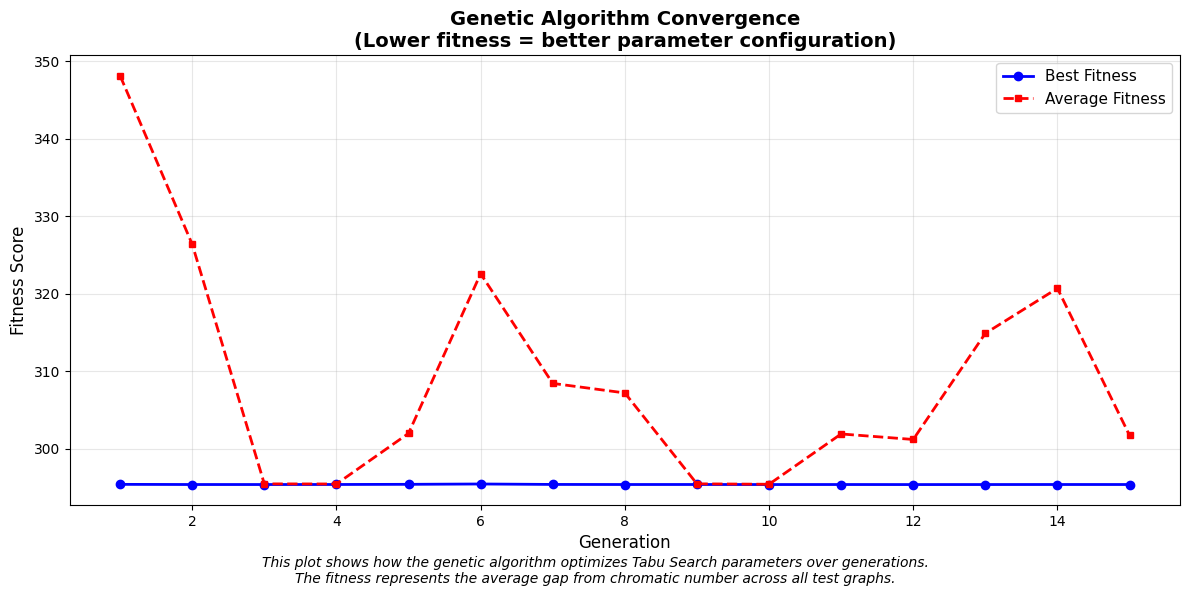

Generating method comparison line plot...


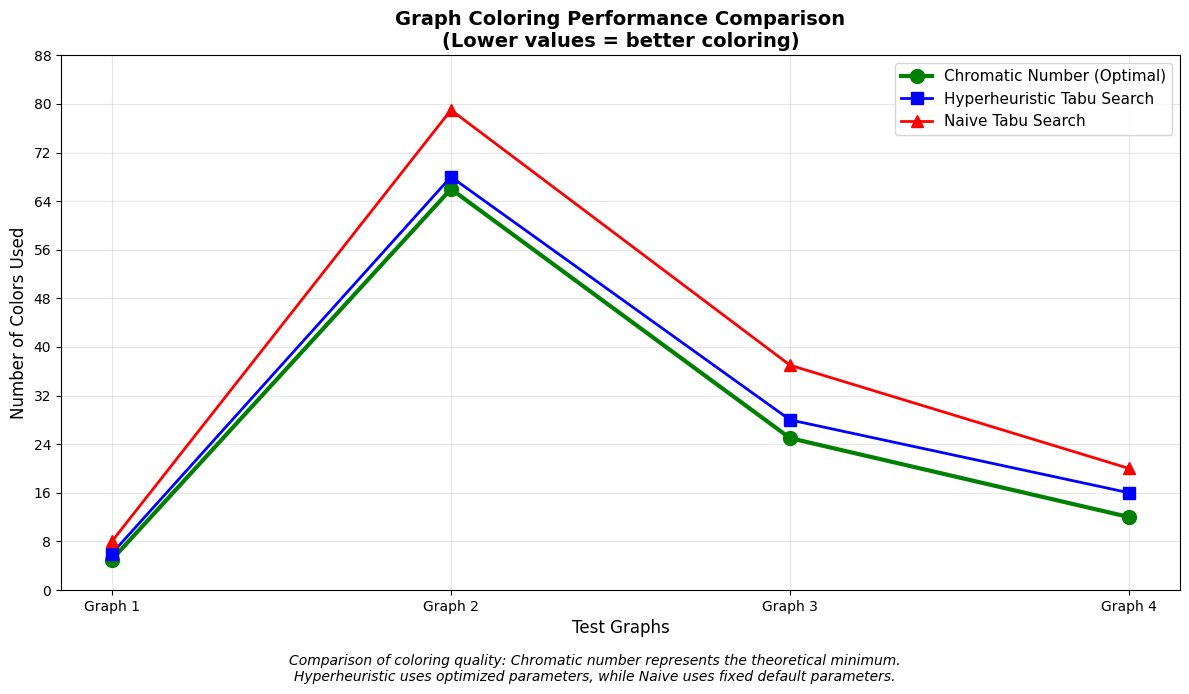

Generating method comparison bar chart...


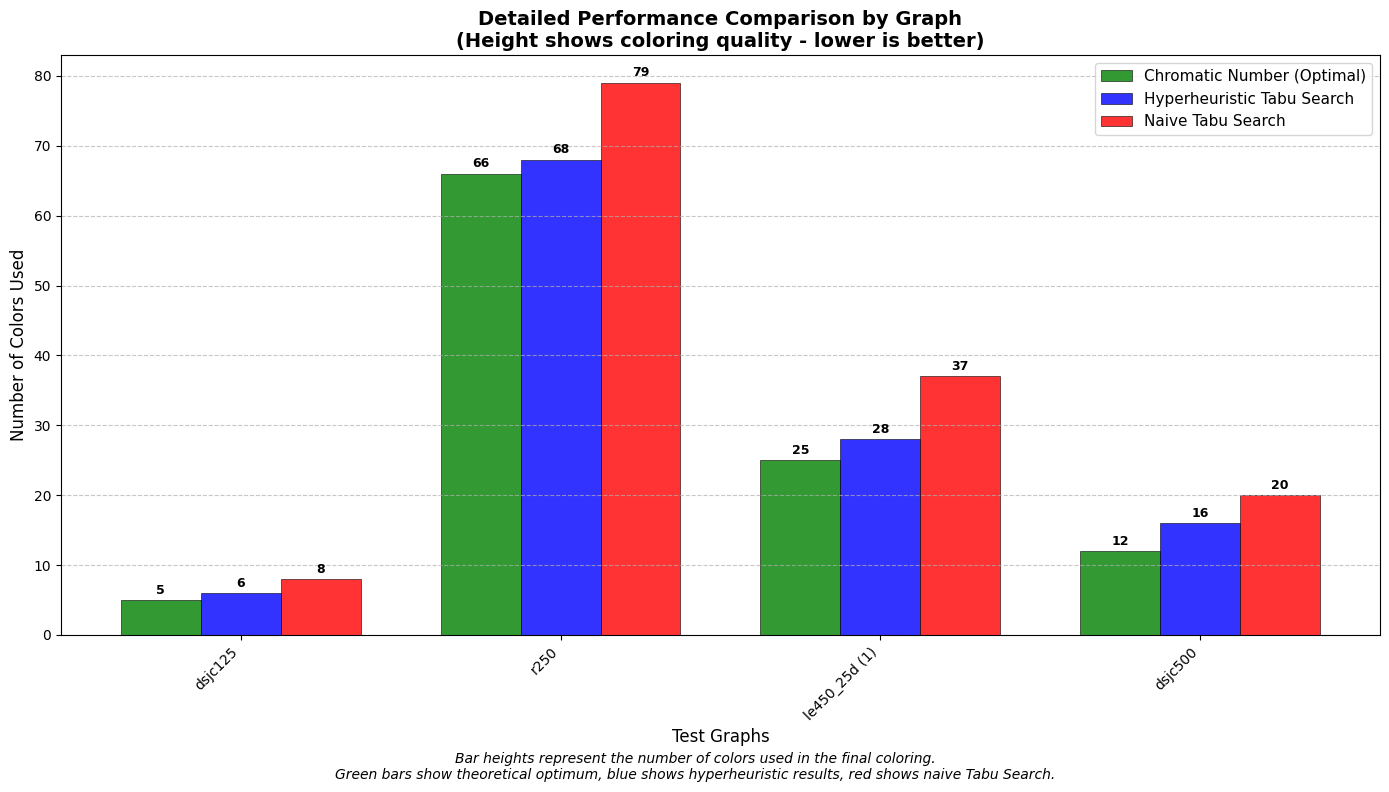


GENERATING DETAILED COMPARISON TABLE


Graph,Optimal,Naive-Colors,Naive-Gap,Naive-Time(s),Hyper-Colors,Hyper-Gap,Hyper-Time(s),Gap Improvement,Improvement %
dsjc125.1 (2).col,5,8,3,0.24,6,1,0.1,+2,66.7%
r250.5 (1).col,66,79,13,1.56,68,2,1.7,+11,84.6%
le450_25d (1).col,25,37,12,1.98,28,3,3.6,+9,75.0%
dsjc500.1 (1).col,12,20,8,1.15,16,4,4.0,+4,50.0%



PERFORMANCE SUMMARY
Naive Tabu Search - Total Gap: 36
Hyperheuristic Approach - Total Gap: 10
Total Gap Improvement: 26
Average Improvement per Graph: 6.5
Overall Performance Improvement: 72.2%

CONCLUSION:
   The hyperheuristic approach achieved 72.2% better performance
   by optimizing Tabu Search parameters using genetic algorithm.

Best Parameters Found:
   TabuSearchParams(init_strategy=2, neighborhood_type=0, tabu_tenure=12, tabu_list_type=1, aspiration_rule=2, acceptance_rule=1, diversify_trigger=44, stop_criterion=1)


In [ ]:
def main():
    """Main function to run the genetic algorithm for tabu search parameter tuning"""
    import networkx.algorithms.clique as clique
    import pandas as pd
    import time
    from IPython.display import display, HTML
    import numpy as np
    import matplotlib.pyplot as plt

    print("Starting genetic algorithm for tabu search parameter tuning...")

    # =================================================================
    # GRAPH LOADING AND CONFIGURATION
    # =================================================================
    use_benchmark = input("Load benchmark files? (y/n): ").lower() == 'y'
    test_graphs = []
    graph_names = []
    chromatic_numbers = []

    if use_benchmark:
        num_graphs = int(input("How many benchmark graphs to load? (1-5): "))
        num_graphs = max(1, min(5, num_graphs))

        for i in range(num_graphs):
            print(f"\nLoading graph {i+1}/{num_graphs}")
            G, filename = charger_graphe_benchmark()
            test_graphs.append(G)
            graph_names.append(filename)
    else:
        num_graphs = int(input("How many random graphs to generate? (3-10): "))
        num_graphs = max(3, min(10, num_graphs))

        print(f"Generating {num_graphs} random graphs...")
        test_graphs = generate_test_graphs(num_graphs)
        graph_names = [f"random_graph_{i+1}" for i in range(num_graphs)]

    print("\nGraph statistics:")
    for i, (G, name) in enumerate(zip(test_graphs, graph_names)):
        print(f"{name}: {G.number_of_nodes()} vertices, {G.number_of_edges()} edges")
        chrom = input(f"Enter chromatic number (or press Enter for auto) for '{name}': ")
        if chrom.strip() == "":
            chrom_bound = len(clique.max_clique(G))
        else:
            chrom_bound = int(chrom)
        chromatic_numbers.append(chrom_bound)

    # =================================================================
    # GENETIC ALGORITHM CONFIGURATION
    # =================================================================
    print("\nGenetic algorithm configuration:")
    max_generations = int(input("Number of generations (5-50, default: 10): ") or "10")
    max_generations = max(5, min(50, max_generations))

    population_size = int(input("Population size (5-50, default: 10): ") or "10")
    population_size = max(5, min(50, population_size))

    time_limit = int(input("Time limit per graph in seconds (1-60, default: 5): ") or "5")
    time_limit = max(1, min(60, time_limit))

    # =================================================================
    # GENETIC ALGORITHM EXECUTION
    # =================================================================
    print("\nStarting genetic algorithm...")

    best_params, best_fitness, history = run_genetic_algorithm(
        test_graphs=test_graphs,
        max_generations=max_generations,
        population_size=population_size,
        num_parents=population_size // 2,
        mutation_rate=0.2,
        num_elites=1,
        time_limit_per_graph=time_limit
    )

    # =================================================================
    # HYPERHEURISTIC VALIDATION
    # =================================================================
    print("\n" + "="*70)
    print("HYPERHEURISTIC VALIDATION")
    print("="*70)
    validation_results = validate_best_params(best_params, test_graphs, chromatic_numbers)

    # =================================================================
    # NAIVE TABU SEARCH EXECUTION
    # =================================================================
    print("\n" + "="*70)
    print("NAIVE TABU SEARCH EXECUTION ON SAME GRAPHS")
    print("="*70)
    print("Running baseline Tabu Search with fixed parameters for comparison...")

    def naive_tabu_search(G, max_iter=500, tabu_tenure=7):
        """Naive Tabu Search with greedy initialization and basic swap neighborhood"""
        # Greedy coloring initialization
        coloring = {}
        for node in G.nodes():
            neighbor_colors = {coloring.get(n) for n in G.neighbors(node)}
            color = 0
            while color in neighbor_colors:
                color += 1
            coloring[node] = color

        best_coloring = coloring.copy()
        best_num_colors = len(set(coloring.values()))
        tabu_list = {}

        for it in range(max_iter):
            # Find most conflicted node
            node = max(G.nodes(), key=lambda n: sum(1 for v in G.neighbors(n) if coloring[n] == coloring[v]))
            old_color = coloring[node]
            neighbor_colors = {coloring[n] for n in G.neighbors(node)}
            available_colors = [c for c in range(best_num_colors + 1) if c != old_color and c not in neighbor_colors]

            if not available_colors:
                continue

            new_color = min(available_colors)
            move = (node, old_color, new_color)

            if move in tabu_list and tabu_list[move] > it:
                continue

            coloring[node] = new_color
            num_colors = len(set(coloring.values()))

            if num_colors < best_num_colors:
                best_coloring = coloring.copy()
                best_num_colors = num_colors

            tabu_list[move] = it + tabu_tenure

        return best_coloring, best_num_colors

    # Execute Naive Tabu Search on all graphs
    naive_tabu_results = {
        "Graph": [],
        "Optimal": [],
        "Colors_Found": [],
        "Gap": [],
        "Time_s": []
    }

    for i, G in enumerate(test_graphs):
        print(f"Processing {graph_names[i]}...")
        start = time.time()
        coloring, nb_colors = naive_tabu_search(G)
        end = time.time()

        optimal = chromatic_numbers[i]
        gap = nb_colors - optimal
        naive_tabu_results["Graph"].append(graph_names[i])
        naive_tabu_results["Optimal"].append(optimal)
        naive_tabu_results["Colors_Found"].append(nb_colors)
        naive_tabu_results["Gap"].append(gap)
        naive_tabu_results["Time_s"].append(round(end - start, 2))

    # =================================================================
    # VISUALIZATION SECTION
    # =================================================================
    print("\n" + "="*70)
    print("GENERATING PERFORMANCE VISUALIZATIONS")
    print("="*70)

    # -------------------------------------------------------------------------
    # GRAPH 1: Genetic Algorithm Fitness Evolution
    # -------------------------------------------------------------------------
    print("Generating fitness evolution plot...")

    generations = list(range(1, len(history['best_fitness']) + 1))

    plt.figure(figsize=(12, 6))
    plt.plot(generations, history['best_fitness'], 'b-o', label='Best Fitness', linewidth=2, markersize=6)
    plt.plot(generations, history['avg_fitness'], 'r--s', label='Average Fitness', linewidth=2, markersize=4)

    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness Score', fontsize=12)
    plt.title('Genetic Algorithm Convergence\n(Lower fitness = better parameter configuration)',
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Add annotation
    plt.figtext(0.5, 0.02,
                'This plot shows how the genetic algorithm optimizes Tabu Search parameters over generations.\n' +
                'The fitness represents the average gap from chromatic number across all test graphs.',
                ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # -------------------------------------------------------------------------
    # GRAPH 2: Method Comparison (Line Plot)
    # -------------------------------------------------------------------------
    print("Generating method comparison line plot...")

    graph_labels = [f"Graph {i+1}" for i in range(len(graph_names))]
    hyper_colors = validation_results["Colors Found"].tolist()
    naive_colors = naive_tabu_results["Colors_Found"]

    plt.figure(figsize=(12, 7))
    plt.plot(graph_labels, chromatic_numbers, marker='o', linestyle='-', color='green',
             label='Chromatic Number (Optimal)', linewidth=3, markersize=10)
    plt.plot(graph_labels, hyper_colors, marker='s', linestyle='-', color='blue',
             label='Hyperheuristic Tabu Search', linewidth=2, markersize=8)
    plt.plot(graph_labels, naive_colors, marker='^', linestyle='-', color='red',
             label='Naive Tabu Search', linewidth=2, markersize=8)

    plt.xlabel('Test Graphs', fontsize=12)
    plt.ylabel('Number of Colors Used', fontsize=12)
    plt.title('Graph Coloring Performance Comparison\n(Lower values = better coloring)',
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Calculate y-axis range
    ymin, ymax = plt.ylim()
    yticks = np.arange(start=0, stop=ymax + 10, step=max(1, int((ymax-0)/10)))
    plt.yticks(yticks)

    # Add annotation
    plt.figtext(0.5, 0.02,
                'Comparison of coloring quality: Chromatic number represents the theoretical minimum.\n' +
                'Hyperheuristic uses optimized parameters, while Naive uses fixed default parameters.',
                ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # -------------------------------------------------------------------------
    # GRAPH 3: Method Comparison (Bar Chart)
    # -------------------------------------------------------------------------
    print("Generating method comparison bar chart...")

    fig, ax = plt.subplots(figsize=(14, 8))

    # Bar positions
    x = np.arange(len(graph_names))
    width = 0.25

    # Create bars
    bars1 = ax.bar(x - width, chromatic_numbers, width, label='Chromatic Number (Optimal)',
                   color='green', alpha=0.8, edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x, hyper_colors, width, label='Hyperheuristic Tabu Search',
                   color='blue', alpha=0.8, edgecolor='black', linewidth=0.5)
    bars3 = ax.bar(x + width, naive_colors, width, label='Naive Tabu Search',
                   color='red', alpha=0.8, edgecolor='black', linewidth=0.5)

    # Add value labels on bars
    for i, v in enumerate(chromatic_numbers):
        ax.text(i - width, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold', fontsize=9)
    for i, v in enumerate(hyper_colors):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold', fontsize=9)
    for i, v in enumerate(naive_colors):
        ax.text(i + width, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold', fontsize=9)

    # Customize plot
    ax.set_xlabel('Test Graphs', fontsize=12)
    ax.set_ylabel('Number of Colors Used', fontsize=12)
    ax.set_title('Detailed Performance Comparison by Graph\n(Height shows coloring quality - lower is better)',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([name.split('.')[0] for name in graph_names], rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add annotation
    plt.figtext(0.5, 0.02,
                'Bar heights represent the number of colors used in the final coloring.\n' +
                'Green bars show theoretical optimum, blue shows hyperheuristic results, red shows naive Tabu Search.',
                ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

    # =================================================================
    # DETAILED COMPARISON TABLE
    # =================================================================
    print("\n" + "="*70)
    print("GENERATING DETAILED COMPARISON TABLE")
    print("="*70)

    # Prepare comparison data
    comparison_data = []
    for i in range(len(graph_names)):
        hyper_colors_val = validation_results.iloc[i]["Colors Found"]
        hyper_gap = validation_results.iloc[i]["Gap"]
        hyper_time = validation_results.iloc[i]["Time (s)"]

        naive_colors_val = naive_tabu_results["Colors_Found"][i]
        naive_gap = naive_tabu_results["Gap"][i]
        naive_time = naive_tabu_results["Time_s"][i]

        improvement_gap = naive_gap - hyper_gap
        improvement_pct = round((improvement_gap / naive_gap * 100), 1) if naive_gap > 0 else 0

        comparison_data.append({
            "Graph": graph_names[i],
            "Chromatic_Number": chromatic_numbers[i],
            "Naive_Colors": naive_colors_val,
            "Naive_Gap": naive_gap,
            "Naive_Time": naive_time,
            "Hyper_Colors": hyper_colors_val,
            "Hyper_Gap": hyper_gap,
            "Hyper_Time": hyper_time,
            "Gap_Improvement": improvement_gap,
            "Improvement_Percent": improvement_pct
        })

    df_comparison = pd.DataFrame(comparison_data)

    # Style functions
    def style_improvement(val):
        if val > 0:
            return f'<span style="color:green; font-weight:bold;">+{val}</span>'
        elif val == 0:
            return f'<span style="color:orange; font-weight:bold;">0</span>'
        else:
            return f'<span style="color:red; font-weight:bold;">{val}</span>'

    def style_percentage(val):
        if val > 0:
            return f'<span style="color:green; font-weight:bold;">{val}%</span>'
        elif val == 0:
            return f'<span style="color:orange; font-weight:bold;">{val}%</span>'
        else:
            return f'<span style="color:red; font-weight:bold;">{val}%</span>'

    # Apply styling
    styled_df = df_comparison.copy()
    styled_df.columns = ["Graph", "Optimal", "Naive-Colors", "Naive-Gap", "Naive-Time(s)",
                        "Hyper-Colors", "Hyper-Gap", "Hyper-Time(s)", "Gap Improvement", "Improvement %"]
    styled_df["Gap Improvement"] = df_comparison["Gap_Improvement"].apply(style_improvement)
    styled_df["Improvement %"] = df_comparison["Improvement_Percent"].apply(style_percentage)

    # CSS styling
    css_style = """
    <style>
    .comparison-table {
        border-collapse: collapse;
        margin: 20px auto;
        font-size: 12px;
        min-width: 95%;
        border-radius: 8px 8px 0 0;
        overflow: hidden;
        box-shadow: 0 4px 20px rgba(0,0,0,0.15);
    }
    .comparison-table thead tr {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: #ffffff;
        text-align: center;
        font-weight: bold;
    }
    .comparison-table th,
    .comparison-table td {
        padding: 10px 8px;
        border: 1px solid #dddddd;
        text-align: center;
    }
    .comparison-table tbody tr {
        border-bottom: 1px solid #dddddd;
    }
    .comparison-table tbody tr:nth-of-type(even) {
        background-color: #f8f9fa;
    }
    .comparison-table tbody tr:hover {
        background-color: #e3f2fd;
        transition: background-color 0.3s;
    }
    </style>
    """

    # Display table
    html_table = styled_df.to_html(escape=False, index=False, classes="comparison-table")
    display(HTML(f"""
    {css_style}
    <div style="text-align: center; margin: 20px 0;">
        <h2 style="color: #333; margin-bottom: 10px;">Comprehensive Method Comparison</h2>
        <p style="color: #666; font-style: italic; margin-bottom: 20px;">
            Detailed performance metrics comparing Naive Tabu Search vs Hyperheuristic approach.<br>
            <strong>Gap</strong> = Colors Used - Chromatic Number | <strong>Lower gaps indicate better performance</strong>
        </p>
    </div>
    {html_table}
    """))

    # =================================================================
    # PERFORMANCE SUMMARY
    # =================================================================
    print("\n" + "="*70)
    print("PERFORMANCE SUMMARY")
    print("="*70)

    total_naive_gap = sum(df_comparison["Naive_Gap"])
    total_hyper_gap = sum(df_comparison["Hyper_Gap"])
    total_improvement = total_naive_gap - total_hyper_gap
    avg_improvement = total_improvement / len(df_comparison)
    global_improvement_pct = (total_improvement / total_naive_gap * 100) if total_naive_gap > 0 else 0

    print(f"Naive Tabu Search - Total Gap: {total_naive_gap}")
    print(f"Hyperheuristic Approach - Total Gap: {total_hyper_gap}")
    print(f"Total Gap Improvement: {total_improvement}")
    print(f"Average Improvement per Graph: {avg_improvement:.1f}")
    print(f"Overall Performance Improvement: {global_improvement_pct:.1f}%")

    print(f"\nCONCLUSION:")
    if global_improvement_pct > 0:
        print(f"   The hyperheuristic approach achieved {global_improvement_pct:.1f}% better performance")
        print(f"   by optimizing Tabu Search parameters using genetic algorithm.")
    else:
        print(f"   Both methods performed similarly on these test instances.")

    print(f"\nBest Parameters Found:")
    print(f"   {best_params}")

    return best_params, validation_results, df_comparison

if __name__ == "__main__":
    main()